# Session 2: Clustering Experimentation

**Objective**: Compare three clustering algorithms (K-Means, Hierarchical, DBSCAN) with parameter tuning.

Focus areas:
- Cluster size distribution (avoid huge "everything" cluster)
- Outlier/noise rate (especially DBSCAN)
- Quality metrics (silhouette score, Davies-Bouldin index)

In [1]:
import sys
sys.path.insert(0, '..')
import os

# Set notebook directory as working directory
notebook_dir = '/Users/diegoaquino/IF4/DataMining/grandlyon-photo-clusters/notebooks'
os.chdir(notebook_dir)
print(f"Working directory: {os.getcwd()}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from src.data_loader import load_cleaned_data
from src.clustering import (
    prepare_coordinates, 
    run_dbscan, run_kmeans, run_hierarchical,
    get_cluster_stats, calculate_quality_metrics,
    compare_algorithms, find_optimal_k
)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries loaded!")

Working directory: /Users/diegoaquino/IF4/DataMining/grandlyon-photo-clusters/notebooks
Libraries loaded!


## 1. Load Data

In [2]:
# Load cleaned data
df = load_cleaned_data()
print(f"Loaded {len(df):,} photos")

# Prepare coordinates
coords = prepare_coordinates(df, scale=False)
coords_scaled = prepare_coordinates(df, scale=True)

print(f"Coordinate range: lat ({coords[:, 0].min():.4f}, {coords[:, 0].max():.4f})")
print(f"                  lon ({coords[:, 1].min():.4f}, {coords[:, 1].max():.4f})")

Loaded 167,578 photos
Coordinate range: lat (45.6552, 45.8550)
                  lon (4.7203, 5.0067)


## 2. DBSCAN Parameter Tuning

Key parameters:
- **eps**: Maximum distance between points (in degrees). 0.001° ≈ 100m
- **min_samples**: Minimum points to form a cluster

In [3]:
# Optimized DBSCAN parameter sweep (Sequential)
from sklearn.metrics import silhouette_score
import numpy as np

# eps_values = [0.002, 0.003, 0.004, 0.005, 0.006]  # 5 values
eps_values = [0.005]

min_samples = 10

# Pre-sample for fast metrics
sample_idx = np.random.choice(len(coords), 10000, replace=False)

def test_eps(eps):
    labels = run_dbscan(coords, eps=eps, min_samples=min_samples)
    stats = get_cluster_stats(labels)
    
    # Silhouette on sample
    mask = labels[sample_idx] != -1
    sil = silhouette_score(coords[sample_idx][mask], labels[sample_idx][mask]) if mask.sum() > 50 else None
    
    return {
        'eps': eps,
        'n_clusters': stats['n_clusters'],
        'noise_pct': round(stats['noise_percentage'], 1),
        'largest_pct': round(stats['largest_cluster'] / len(labels) * 100, 1),
        'silhouette': round(sil, 4) if sil else None
    }

print(f"Testing {len(eps_values)} eps values...")
results = []
for i, eps in enumerate(eps_values):
    print(f"  [{i+1}/{len(eps_values)}] eps={eps}")
    results.append(test_eps(eps))
    
dbscan_df = pd.DataFrame(results)
dbscan_df

Testing 1 eps values...
  [1/1] eps=0.005


,eps,n_clusters,noise_pct,largest_pct,silhouette
0,0.005,59,0.3,83.8,0.4098


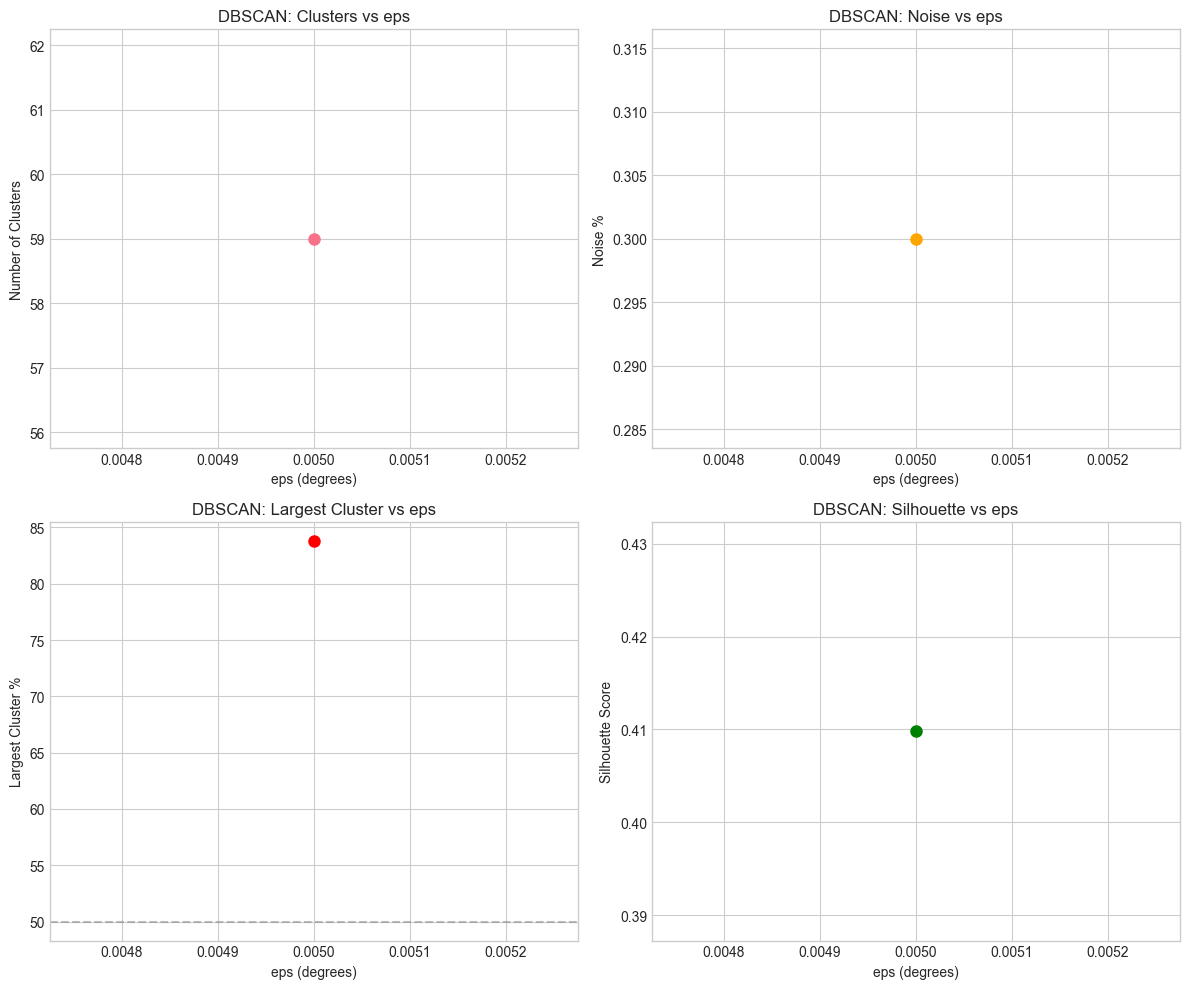


✅ Best DBSCAN parameters (by silhouette):
   eps = 0.005, silhouette = 0.4098


In [4]:
# Visualize DBSCAN parameter sweep
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Number of clusters
axes[0, 0].plot(dbscan_df['eps'], dbscan_df['n_clusters'], 'o-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('eps (degrees)')
axes[0, 0].set_ylabel('Number of Clusters')
axes[0, 0].set_title('DBSCAN: Clusters vs eps')

# Noise percentage
axes[0, 1].plot(dbscan_df['eps'], dbscan_df['noise_pct'], 'o-', linewidth=2, markersize=8, color='orange')
axes[0, 1].set_xlabel('eps (degrees)')
axes[0, 1].set_ylabel('Noise %')
axes[0, 1].set_title('DBSCAN: Noise vs eps')

# Largest cluster percentage
axes[1, 0].plot(dbscan_df['eps'], dbscan_df['largest_pct'], 'o-', linewidth=2, markersize=8, color='red')
axes[1, 0].set_xlabel('eps (degrees)')
axes[1, 0].set_ylabel('Largest Cluster %')
axes[1, 0].set_title('DBSCAN: Largest Cluster vs eps')
axes[1, 0].axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% threshold')

# Silhouette score
axes[1, 1].plot(dbscan_df['eps'], dbscan_df['silhouette'], 'o-', linewidth=2, markersize=8, color='green')
axes[1, 1].set_xlabel('eps (degrees)')
axes[1, 1].set_ylabel('Silhouette Score')
axes[1, 1].set_title('DBSCAN: Silhouette vs eps')

plt.tight_layout()
plt.savefig('../reports/dbscan_parameter_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

# Find best eps
best_dbscan = dbscan_df.loc[dbscan_df['silhouette'].idxmax()]
print(f"\n✅ Best DBSCAN parameters (by silhouette):")
print(f"   eps = {best_dbscan['eps']}, silhouette = {best_dbscan['silhouette']:.4f}")

## 3. K-Means Parameter Tuning

Key parameter: **k** (number of clusters)

Methods to find optimal k:
- Elbow method (inertia)
- Silhouette score

In [5]:
# Proper k range for ~168K points
k_range = [20, 30, 40, 50, 60, 80, 100, 120, 150]
kmeans_results = find_optimal_k(coords_scaled, k_range=k_range)
kmeans_df = pd.DataFrame(kmeans_results)
kmeans_df

  Testing k=20... silhouette=0.5009
  Testing k=30... silhouette=0.4933
  Testing k=40... silhouette=0.4900
  Testing k=50... silhouette=0.4967
  Testing k=60... silhouette=0.5237
  Testing k=80... silhouette=0.5167
  Testing k=100... silhouette=0.5344
  Testing k=120... silhouette=0.5414
  Testing k=150... silhouette=0.5389


,k,inertia,silhouette
0,20,12481.355062,0.500908
1,30,7172.407408,0.493295
2,40,5217.353995,0.489970
3,50,3981.678714,0.496737
4,60,3160.776043,0.523747
5,80,2262.988653,0.516712
6,100,1584.122113,0.534400
7,120,1241.429714,0.541444
8,150,927.519180,0.538856


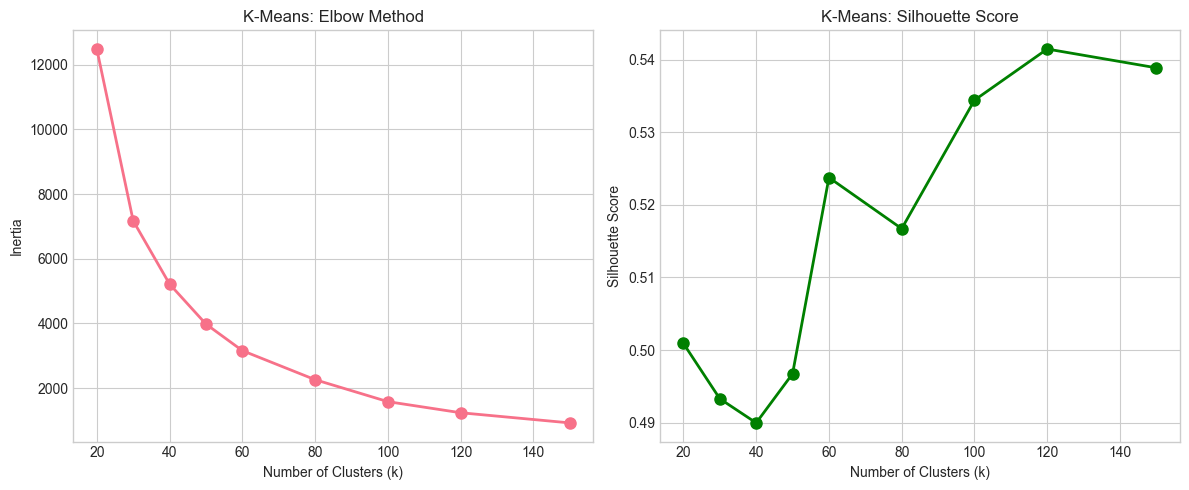


✅ Best K-Means parameters (by silhouette):
   k = 120, silhouette = 0.5414


In [6]:
# Visualize K-Means parameter sweep
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Elbow method
axes[0].plot(kmeans_df['k'], kmeans_df['inertia'], 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('K-Means: Elbow Method')

# Silhouette score
axes[1].plot(kmeans_df['k'], kmeans_df['silhouette'], 'o-', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('K-Means: Silhouette Score')

plt.tight_layout()
plt.savefig('../reports/kmeans_parameter_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

# Find best k
best_kmeans = kmeans_df.loc[kmeans_df['silhouette'].idxmax()]
print(f"\n✅ Best K-Means parameters (by silhouette):")
print(f"   k = {int(best_kmeans['k'])}, silhouette = {best_kmeans['silhouette']:.4f}")

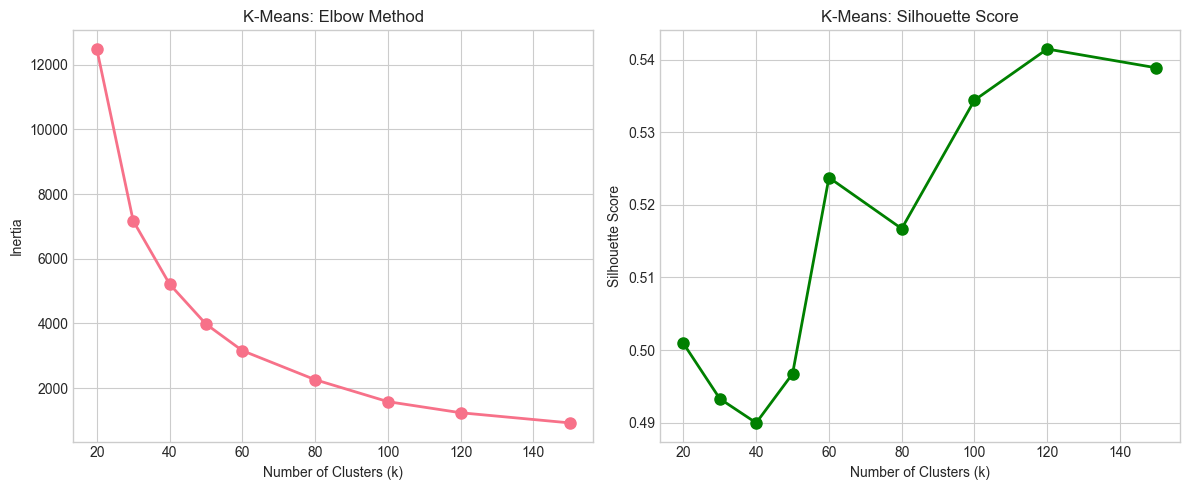

Combined with silhouette: The elbow suggests k=60-80, but silhouette peaks at k=120. A reasonable choice is k=100 (compromise).


In [7]:
# force k = 100

best_kmeans = kmeans_df.loc[kmeans_df['k'] == 100].iloc[0]
print(best_kmeans)

k              100.000000
inertia       1584.122113
silhouette       0.534400
Name: 6, dtype: float64


## 4. Hierarchical Clustering Parameter Tuning

Key parameters:
- **n_clusters**: Number of clusters
- **linkage**: How to measure distance between clusters

In [8]:
# Memory-safe Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# n_clusters_values = [20, 30, 40, 50, 60, 80, 100, 120]
# linkages = ['ward', 'complete', 'average']
n_clusters_values = [100]
linkages = ['ward']

# Use a manageable sample size for hierarchical
HIER_SAMPLE = 20000  # Adjust based on your RAM (20k is usually safe)
sample_idx = np.random.choice(len(coords), min(HIER_SAMPLE, len(coords)), replace=False)
coords_sample = coords[sample_idx]

hier_results = []
total = len(linkages) * len(n_clusters_values)

print(f"Testing {total} combinations on {len(coords_sample):,} sampled points...")

for i, linkage in enumerate(linkages):
    for j, n_clusters in enumerate(n_clusters_values):
        step = i * len(n_clusters_values) + j + 1
        print(f"  [{step}/{total}] {linkage}, k={n_clusters}", end='   \r')
        
        # Cluster the sample
        model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        labels_sample = model.fit_predict(coords_sample)
        
        # Metrics on sample
        sil = silhouette_score(coords_sample, labels_sample)
        db = davies_bouldin_score(coords_sample, labels_sample)
        
        # Basic stats
        unique, counts = np.unique(labels_sample, return_counts=True)
        
        hier_results.append({
            'n_clusters': n_clusters,
            'linkage': linkage,
            'largest_pct': round(counts.max() / len(labels_sample) * 100, 2),
            'median_size': int(np.median(counts)),
            'silhouette': round(sil, 4),
            'davies_bouldin': round(db, 4)
        })

print(f"\n✅ Done!")
hier_df = pd.DataFrame(hier_results)
hier_df.head(15)

Testing 1 combinations on 20,000 sampled points...
  [1/1] ward, k=100   
✅ Done!


,n_clusters,linkage,largest_pct,median_size,silhouette,davies_bouldin
0,100,ward,9.14,83,0.513,0.6611


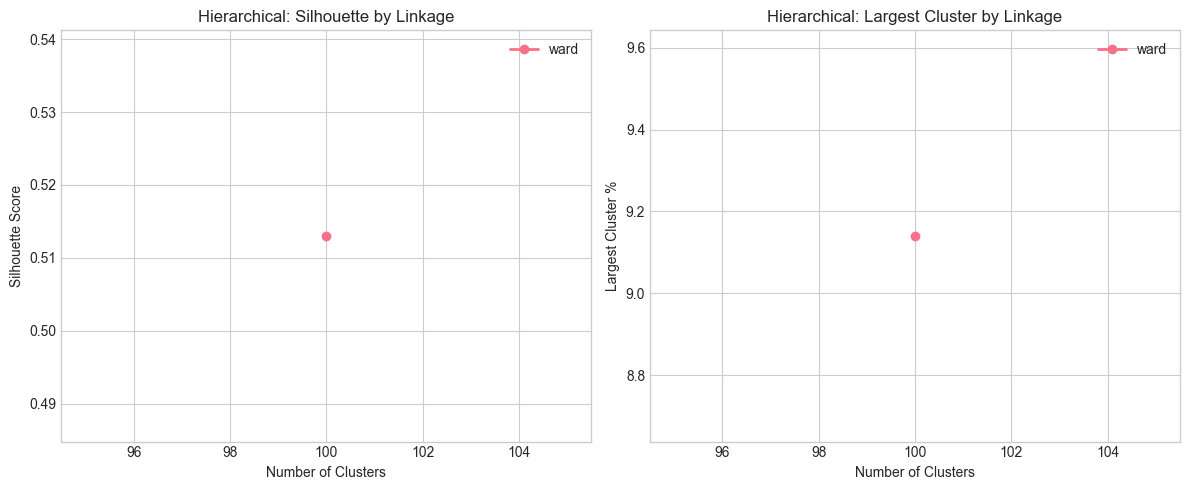


✅ Best Hierarchical parameters (by silhouette):
   n_clusters = 100, linkage = ward
   silhouette = 0.5130


In [9]:
# Visualize Hierarchical parameter sweep
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for linkage in linkages:
    subset = hier_df[hier_df['linkage'] == linkage]
    axes[0].plot(subset['n_clusters'], subset['silhouette'], 'o-', label=linkage, linewidth=2, markersize=6)
    axes[1].plot(subset['n_clusters'], subset['largest_pct'], 'o-', label=linkage, linewidth=2, markersize=6)

axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Hierarchical: Silhouette by Linkage')
axes[0].legend()

axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Largest Cluster %')
axes[1].set_title('Hierarchical: Largest Cluster by Linkage')
axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/hierarchical_parameter_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

# Find best hierarchical config
best_hier = hier_df.loc[hier_df['silhouette'].idxmax()]
print(f"\n✅ Best Hierarchical parameters (by silhouette):")
print(f"   n_clusters = {int(best_hier['n_clusters'])}, linkage = {best_hier['linkage']}")
print(f"   silhouette = {best_hier['silhouette']:.4f}")

In [10]:
# Force best hierarchical: ward linkage, k=100
best_hier = hier_df.loc[(hier_df['linkage'] == 'ward') & (hier_df['n_clusters'] == 100)].iloc[0]

print(f"\n✅ Selected Hierarchical parameters:")
print(f"   linkage = {best_hier['linkage']}, k = {int(best_hier['n_clusters'])}")
print(f"   silhouette = {best_hier['silhouette']:.4f}")


✅ Selected Hierarchical parameters:
   linkage = ward, k = 100
   silhouette = 0.5130


## 5. Final Comparison with Best Parameters

In [11]:
# Run comparison with tuned parameters
best_dbscan_eps = float(best_dbscan['eps'])
best_kmeans_k = int(best_kmeans['k'])
best_hier_k = int(best_hier['n_clusters'])

print(f"Using best parameters:")
print(f"  DBSCAN: eps={best_dbscan_eps}, min_samples=10")
print(f"  K-Means: k={best_kmeans_k}")
print(f"  Hierarchical: n_clusters={best_hier_k}, linkage={best_hier['linkage']}")
print()

comparison_df = compare_algorithms(
    df=df,
    dbscan_params={'eps': best_dbscan_eps, 'min_samples': 10},
    kmeans_k=best_kmeans_k,
    hierarchical_k=best_hier_k
)

Using best parameters:
  DBSCAN: eps=0.005, min_samples=10
  K-Means: k=100
  Hierarchical: n_clusters=100, linkage=ward

CLUSTERING ALGORITHM COMPARISON (Optimized)
Data points: 167,578

[1/3] Running DBSCAN (eps=0.005, min_samples=10)...
      → 59 clusters, 0.3% noise
[2/3] Running K-Means (k=100)...
      → 100 clusters
[3/3] Running Hierarchical (k=100, linkage=ward) on 20,000 sample...
      → 100 clusters

COMPARISON RESULTS
   algorithm                         parameters  n_clusters  noise_pct  largest_cluster  largest_pct  median_size  silhouette  davies_bouldin
      DBSCAN          eps=0.005, min_samples=10          59       0.28           140409         83.8           47      0.4044          0.2889
     K-Means                 k=100, scaled=True         100       0.00            15157          9.0          771      0.5347          0.6174
Hierarchical k=100, linkage=ward, sampled=20000         100       0.00             1891          9.5           85      0.5105          0.6

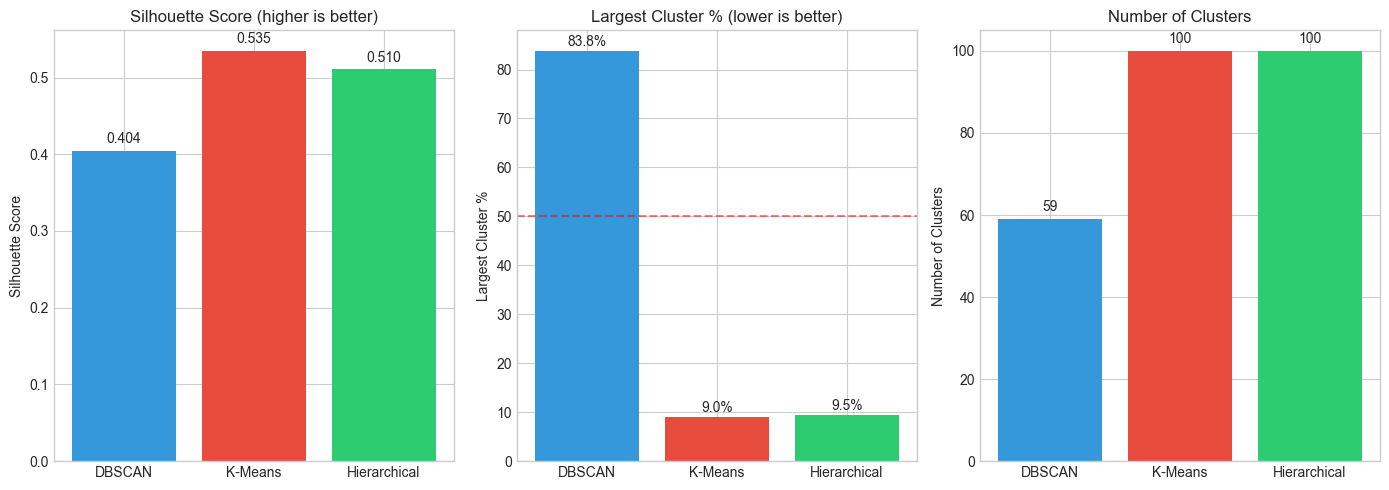

In [12]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Silhouette scores
colors = ['#3498db', '#e74c3c', '#2ecc71']
axes[0].bar(comparison_df['algorithm'], comparison_df['silhouette'], color=colors)
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score (higher is better)')
for i, v in enumerate(comparison_df['silhouette']):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Largest cluster percentage
axes[1].bar(comparison_df['algorithm'], comparison_df['largest_pct'], color=colors)
axes[1].set_ylabel('Largest Cluster %')
axes[1].set_title('Largest Cluster % (lower is better)')
axes[1].axhline(y=50, color='red', linestyle='--', alpha=0.5)
for i, v in enumerate(comparison_df['largest_pct']):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center')

# Number of clusters
axes[2].bar(comparison_df['algorithm'], comparison_df['n_clusters'], color=colors)
axes[2].set_ylabel('Number of Clusters')
axes[2].set_title('Number of Clusters')
for i, v in enumerate(comparison_df['n_clusters']):
    axes[2].text(i, v + 2, str(v), ha='center')

plt.tight_layout()
plt.savefig('../reports/clustering_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Save Results

In [13]:
# Save all parameter sweep results
dbscan_df.to_csv('../reports/dbscan_tuning.csv', index=False)
kmeans_df.to_csv('../reports/kmeans_tuning.csv', index=False)
hier_df.to_csv('../reports/hierarchical_tuning.csv', index=False)
comparison_df.to_csv('../reports/clustering_comparison.csv', index=False)

# Save best parameters summary
best_params = {
    'timestamp': datetime.now().isoformat(),
    'dbscan': {
        'eps': best_dbscan_eps,
        'min_samples': 10,
        'silhouette': float(best_dbscan['silhouette']),
        'n_clusters': int(best_dbscan['n_clusters'])
    },
    'kmeans': {
        'k': best_kmeans_k,
        'silhouette': float(best_kmeans['silhouette'])
    },
    'hierarchical': {
        'n_clusters': best_hier_k,
        'linkage': best_hier['linkage'],
        'silhouette': float(best_hier['silhouette'])
    }
}

import json
with open('../reports/best_clustering_params.json', 'w') as f:
    json.dump(best_params, f, indent=2)

print("✅ All results saved to reports/")
print(f"   - dbscan_tuning.csv")
print(f"   - kmeans_tuning.csv")
print(f"   - hierarchical_tuning.csv")
print(f"   - clustering_comparison.csv")
print(f"   - best_clustering_params.json")

✅ All results saved to reports/
   - dbscan_tuning.csv
   - kmeans_tuning.csv
   - hierarchical_tuning.csv
   - clustering_comparison.csv
   - best_clustering_params.json


## 7. Summary & Recommendations

In [14]:
print("=" * 70)
print("CLUSTERING EXPERIMENTATION SUMMARY")
print("=" * 70)
print()
print("Best parameters found:")
print()
print(f"  DBSCAN:       eps={best_dbscan_eps}, min_samples=10")
print(f"                → {int(best_dbscan['n_clusters'])} clusters, {best_dbscan['noise_pct']:.1f}% noise")
print(f"                → Silhouette: {best_dbscan['silhouette']:.4f}")
print()
print(f"  K-Means:      k={best_kmeans_k}")
print(f"                → Silhouette: {best_kmeans['silhouette']:.4f}")
print()
print(f"  Hierarchical: n_clusters={best_hier_k}, linkage={best_hier['linkage']}")
print(f"                → Silhouette: {best_hier['silhouette']:.4f}")
print()
print("=" * 70)
print("Key observations:")
print("-" * 70)
print("1. DBSCAN identifies natural density-based clusters + noise")
print("2. K-Means creates equal-sized partitions (good for even distribution)")
print("3. Hierarchical with Ward linkage creates compact clusters")
print()
print("Recommendation: Compare visually on the map to decide final algorithm!")
print("=" * 70)

CLUSTERING EXPERIMENTATION SUMMARY

Best parameters found:

  DBSCAN:       eps=0.005, min_samples=10
                → 59 clusters, 0.3% noise
                → Silhouette: 0.4098

  K-Means:      k=100
                → Silhouette: 0.5344

  Hierarchical: n_clusters=100, linkage=ward
                → Silhouette: 0.5130

Key observations:
----------------------------------------------------------------------
1. DBSCAN identifies natural density-based clusters + noise
2. K-Means creates equal-sized partitions (good for even distribution)
3. Hierarchical with Ward linkage creates compact clusters

Recommendation: Compare visually on the map to decide final algorithm!
